# Филтрирање на слика во фреквенциски домен

## Теорија

За да филтрираме слика во фреквенциски домен 
потребно е да ја помножиме сликата во фреквенциски 
домен со филтерот (кернел) кој е исто така во фреквенциски домен.

$$I_{f,filt} = HI_f$$

За таа цел потребно е да се вметне Octave функција која ќе креира “Band pass gaussian filter” во фреквенциски домен. Bandpass гаусовиот филтер во фреквенциски домен е дефиниран со равенката:


$$H(i,j)=e^{-\dfrac{d(i,j)^2}{f_{h}^{2}}}\left(1-e^{-\dfrac{d(i,j)^2}{f_{l}^{2}}}\right)$$

Каде што $d(i,j)$ е евклидовото растојанието на даден пиксел од центарот на сликата, додека $f_h$ и $f_l$ се праговите на високите и ниските фреквенции кои сакаме да ги филтрираме.
Конверзија на 2D сликата од просторен во фреквенциски домен се прави со користење на Фуриева трансформација. Фуриевата трансформација е дефинирана како:

$$F(u,v)=\underset{-\infty}\iint^{\infty}f(x,y)e^{-i2\pi(ux+vy)}dxdy$$

А во дискретниот домен горната равенка може да биде преведена како

$$F(u,v) = \displaystyle\sum_{m=-\infty}^{\infty} \sum_{n=-\infty}^{\infty} f[m,n] \cdot e^ {-i2\pi(umx_0+vny_0)}$$
        
Конверзија на 2D сликата од фреквенциски во просторен домен се прави со
користење на инверзна Фуриева трансформација. Инверзната Фуриева
трансформација е дефинирана како:

$$f(x,y)=\underset{-\infty}\iint^{\infty}F(u,v)e^{i2\pi(ux+vy)}dudv$$

А во дискретниот домен горната равенка може да биде преведена како

$$F(x,y) = \displaystyle\sum_{m=-\infty}^{\infty} \sum_{n=-\infty}^{\infty} f[m,n] \cdot e^ {i2\pi(xmu_0+ynv_0)}$$

## Имплементација и визуелизација

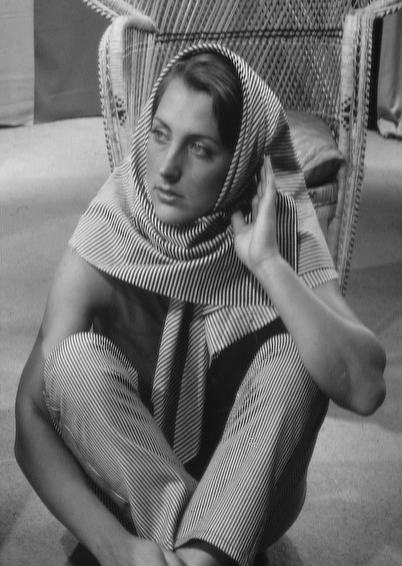

In [1]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
pil_im = Image.open('Requirements/Barbara.tif', 'r')
display(pil_im)

Фуриева трансформација на слика се прави на следниот начин:

<IPython.core.display.Javascript object>


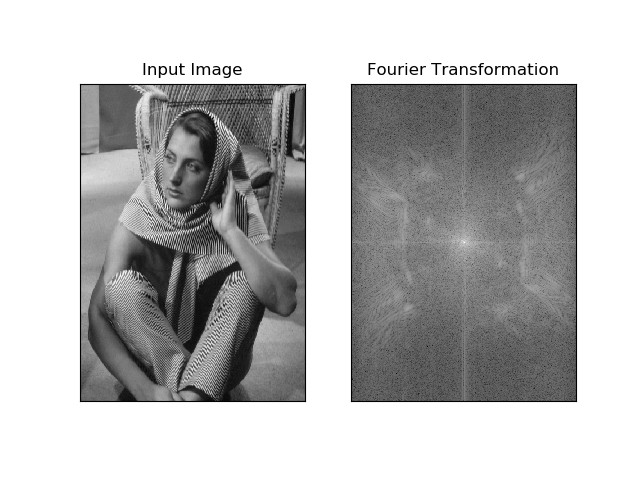

In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('Requirements/Barbara.tif',0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Fourier Transformation'), plt.xticks([]), plt.yticks([])
plt.show()

In [1]:
%%file create_filter.m

function filter = create_filter(nx,ny,d0,d1)
    filter = ones(nx,ny);
    for i = 0:nx-1
        for j = 0:ny-1
            dist= sqrt((i-nx/2)^2 + (j-ny/2)^2);
            filter(i+1,j+1) = exp(-(dist^2)/(d1^2)).*(1.0-exp(-(dist^2)/(d0^2)));
        end
    end
    filter(nx/2+1,ny/2+1)=1;
end

Created file '/home/david/Desktop/mikt/create_filter.m'.


In [2]:
clear all
%read image
im = double(imread('Requirements/Barbara.tif'));
%size of the image
[nx ny] = size(im);
%Transform the image from spatial to frequency domain
im_fft = fftshift(fft2(im));
% Create Gaussian bandpass kernels, in frequency domain, for 20 different cut off frequencies and filter the image
p=1;
for i = 1:10:101
q=1;
    for j = 1:10:101
        %Create the bandpass kernel
        tmp1 = create_filter(nx,ny,i,j);
        %Filter the image with the bandpass kernel and transform it back to spatial domain
        tmp = mat2gray(abs(ifft2(ifftshift(tmp1.*im_fft))));
        %Save the filtered image (in spatial domain) and kernel (in frequency domain) for visualization 
        filtered_image(p,q,:) = tmp(:);
        filter_kernel(p,q,:) = tmp1(:);
        q=q+1;
    end
    p=p+1;
end
save filtered_image
save filter_kernel

In [1]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

%matplotlib nbagg

value = widgets.IntRangeSlider(
    value=[0, 10],
    min=0,
    max=10,
    step=1,
    description='Frequency cutoffs:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout={'width': '100%'}
)

def show_image(value_0, value_1):
    import scipy.io as sio
    from matplotlib import pyplot as plt
    import numpy as np
    filtered_image = sio.loadmat('filtered_image.mat')
    filt_images = filtered_image['filtered_image']
    temp = filt_images[value_0][value_1][0:]
    temp = temp.reshape(402,566)
    temp = np.rot90(temp)
    temp = np.rot90(temp)
    temp = np.rot90(temp)
    return temp;
    
def show_kernel(value_0, value_1):
    import scipy.io as sio
    from matplotlib import pyplot as plt
    import numpy as np
    filtered_kernel = sio.loadmat('filter_kernel.mat')
    filt_kernels = filtered_kernel['filter_kernel']
    temp = filt_kernels[value_0][value_1][0:]
    temp = temp.reshape(402,566)
    temp = np.rot90(temp)
    temp = np.rot90(temp)
    temp = np.rot90(temp)
    return temp;

def update_plot(value):
    value_0 = value[0]
    value_1 = value[1]
    display(value)
    image = show_image(value_0, value_1)
    kernel = show_kernel(value_0, value_1)
    img_A = (image)
    img_B = (kernel)
    plot_image = np.concatenate((img_A, img_B), axis=1)
    plt.imshow(plot_image, cmap="gray")
    plt.axis('off')
    plt.show()

widgets.interactive(update_plot, value=value)

interactive(children=(IntRangeSlider(value=(0, 10), continuous_update=False, description='Frequency cutoffs:',…

In [1]:
import dash
import dash_html_components as html
import dash_core_components as dcc
import base64


external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']


image_filename = '/home/david/Desktop/mikt/Requirements/Barbara.png' # replace with your own image
encoded_image = base64.b64encode(open(image_filename, 'rb').read())

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
app.layout = html.Div([
    html.Div("Frequency cutoffs:"),
    dcc.RangeSlider(
        id='my-range-slider',
        min=0,
        max=10,
        step=1,
        value=[1, 4],
        allowCross=False,
        marks={
            0: '0',
            1: '1',
            2: '2',
            3: '3',
            4: '4',
            5: '5',
            6: '6',
            7: '7',
            8: '8',
            9: '9',
            10: '10'
        }
    ),
    html.Div(id='output-container-range-slider'),
    html.Img(id='output-container-range-slider-2')
    #html.Img(src='data:image/png;base64,{}'.format(encoded_image.decode()))
])


@app.callback(
    dash.dependencies.Output('output-container-range-slider', 'children'),
    [dash.dependencies.Input('my-range-slider', 'value')])
    
def update_output(value):
    return 'Ја избравте вредноста "{}"'.format(value)

@app.callback(
    dash.dependencies.Output('output-container-range-slider-2', 'children'),
    [dash.dependencies.Input('my-range-slider', 'value')])
   
def update_output_2(value):
    import scipy.io as sio
    from matplotlib import pyplot as plt
    import numpy as np
    import plotly.express as px
 
    filtered_image = sio.loadmat('filtered_image.mat')
    filtered_kernel = sio.loadmat('filter_kernel.mat')
    filt_images = filtered_image['filtered_image']
    filt_kernels = filtered_kernel['filter_kernel']
    temp = filt_kernels[value[0]][value[1]][0:]
    temp = temp.reshape(402,566)
    temp = np.rot90(temp)
    #print(temp)
 
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import plotly.express as px
    import numpy as np
    img = temp
    fig = px.imshow(img, color_continuous_scale='gray')
    fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
    return fig.show()

if __name__ == '__main__':
    app.run_server(port=8329,
                   debug=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8329/ (Press CTRL+C to quit)
127.0.0.1 - - [22/Dec/2019 16:19:32] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/Dec/2019 16:19:32] "GET /_dash-component-suites/dash_renderer/polyfill@7.v1_2_2m1576710099.7.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Dec/2019 16:19:32] "GET /_dash-component-suites/dash_renderer/react@16.v1_2_2m1576710099.8.6.min.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Dec/2019 16:19:32] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_2_2m1576710099.8.6.min.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Dec/2019 16:19:32] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_2_2m1576710099.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Dec/2019 16:19:32] "GET /_dash-component-suites/dash_core_components/dash_core_components.v1_6_0m1576710100.min.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Dec/2019 16:19:32] "GET /_dash-component-suites/dash_html_components/dash_html_components.v1_0_2m1576710101.min.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Dec/2019 16:19:32